In [2]:
import glob
import regex as re
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
%load_ext rpy2.ipython
%run ../airquality/data/gen_daily_targets.py

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [3]:
with open('../data/headers_mod.csv') as f:
    mod_headers = f.readlines()[0].split()
    
with open('../data/headers_obs.csv') as f:
    obs_headers = f.readlines()[0].split()
    
mod_headers, obs_headers

(['lon', 'lat', 'day', 'hour', 'AirPollutant', 'Concentration'],
 ['Countrycode',
  'Namespace',
  'AirQualityNetwork',
  'AirQualityStation',
  'AirQualityStationEoICode',
  'SamplingPoint',
  'SamplingProcess',
  'Sample',
  'AirPollutant',
  'AirPollutantCode',
  'AveragingTime',
  'Concentration',
  'UnitOfMeasurement',
  'DatetimeBegin',
  'DatetimeEnd',
  'Validity',
  'Verification'])

In [4]:
test = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')

In [5]:
observations = []
for folder in glob.glob('../data/obs/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[1])
        data = pd.read_csv(file, sep='\t', names=obs_headers)
        data['year'] = year
        data['station'] = station
        observations.append(data)
        
observations = pd.concat(observations)
observations = observations[[c for c in observations.columns if c not in [
    'Countrycode',
    'Namespace',
    'AirQualityNetwork',
    'AirQualityStation',
    'AirQualityStationEoICode',
    'SamplingPoint',
    'SamplingProcess',
    'AveragingTime',
    'UnitOfMeasurement',
    'AirPollutant',
    'AirPollutantCode',
    'Validity',
    'Verification',
    'DatetimeEnd',
    'Sample'
]]]
observations['datetime'] = pd.to_datetime(observations['DatetimeBegin'])
observations = observations.drop('DatetimeBegin', axis=1)
observations = observations.sort_values('datetime')
observations['day'] = observations['datetime'].apply(lambda dt: dt.date())
observations['time'] = observations['datetime'].apply(lambda dt: dt.time())
observations = pd.merge(observations, gen_daily_targets(observations)[['day', 'target']], how='left', on='day')
observations.to_csv('../data/observations.csv')
observations.head(5)

,Concentration,year,station,datetime,day,time,target
0,19,2013,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
1,19,2013,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
2,19,2013,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
3,19,2013,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
4,19,2013,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00,0


In [11]:
observations.sample(10)

,Concentration,year,station,datetime,day,time,target
374466,7,2013,ES1856A,2013-11-23 03:00:00,2013-11-23,03:00:00,0
366450,6,2013,ES1856A,2013-11-16 05:00:00,2013-11-16,05:00:00,0
655901,64,2014,ES1856A,2014-07-24 06:00:00,2014-07-24,06:00:00,0
911504,73,2015,ES1480A,2015-04-02 23:00:00,2015-04-02,23:00:00,0
412374,40,2013,ES1438A,2013-12-25 18:00:00,2013-12-25,18:00:00,0
146903,23,2013,ES0691A,2013-05-10 13:00:00,2013-05-10,13:00:00,0
859714,58,2015,ES1438A,2015-01-26 10:00:00,2015-01-26,10:00:00,0
224055,64,2013,ES1438A,2013-07-15 20:00:00,2013-07-15,20:00:00,0
584253,23,2014,ES1992A,2014-05-23 16:00:00,2014-05-23,16:00:00,0
757044,110,2014,ES1856A,2014-10-20 19:00:00,2014-10-20,19:00:00,0


In [6]:
observations.groupby(['year', 'station']).agg({
    'Concentration': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'datetime': ['min', 'max'],
    'target': ['sum']
})

Concentration                                         datetime  \
                      mean   std    var  count min  max                 min   
year station                                                                  
2013 ES0691A         39.98 22.47 505.01  60314   1  135 2013-01-01 01:00:00   
     ES1396A         33.62 22.02 484.85  60224   1  163 2013-01-01 01:00:00   
     ES1438A         56.73 27.00 729.03  58892   1  253 2013-01-01 01:00:00   
     ES1480A         54.54 27.60 761.85  60402   1  229 2013-01-01 01:00:00   
     ES1679A         35.31 23.29 542.48  60183   1  183 2013-01-01 01:00:00   
     ES1856A         27.49 21.44 459.72  59281   1  147 2013-01-01 01:00:00   
     ES1992A         32.63 24.11 581.09  60156   1  183 2013-01-01 01:00:00   
2014 ES0691A         39.33 22.69 514.97  59905   3  141 2013-12-31 23:00:00   
     ES1396A         32.14 20.55 422.28  59955   3  158 2013-12-31 23:00:00   
     ES1438A         52.33 23.83 567.65  59742   7  170 2013-12-31 23:00:00   
     ES1480A         51.81 26.63 709.33  59930   3  202 2013-12-31 23:00:00   
     ES1679A         37.21 22.98 528.20  60383   1  132 2013-12-31 23:00:00   
     ES1856A         28.45 21.61 466.93  60075   1  157 2013-12-31 23:00:00   
     ES1992A         31.21 23.84 568.50  59989   1  189 2013-12-31 23:00:00   
2015 ES0691A         45.18 24.78 614.25  39281   4  166 2014-12-31 23:00:00   
     ES1396A         36.53 23.23 539.53  37779   1  172 2014-12-31 23:00:00   
     ES1438A         56.99 25.11 630.37  38817   8  178 2014-12-31 23:00:00   
     ES1480A         54.91 27.94 780.74  38354   1  217 2014-12-31 23:00:00   
     ES1679A         42.40 24.77 613.73  39580   1  172 2014-12-31 23:00:00   
     ES1856A         32.26 23.80 566.43  39578   1  169 2014-12-31 23:00:00   
     ES1992A         34.90 24.87 618.51  38828   1  195 2014-12-31 23:00:00   

                                 target  
                             max    sum  
year station                             
2013 ES0691A 2013-12-31 23:00:00   2122  
     ES1396A 2013-12-31 23:00:00   2142  
     ES1438A 2013-12-31 23:00:00   1919  
     ES1480A 2013-12-31 23:00:00   2128  
     ES1679A 2013-12-31 23:00:00   2139  
     ES1856A 2013-12-31 23:00:00   2050  
     ES1992A 2013-12-31 23:00:00   2074  
2014 ES0691A 2014-12-31 23:00:00   1469  
     ES1396A 2014-12-31 23:00:00   1526  
     ES1438A 2014-12-31 23:00:00   1548  
     ES1480A 2014-12-31 23:00:00   1539  
     ES1679A 2014-12-31 23:00:00   1539  
     ES1856A 2014-12-31 23:00:00   1544  
     ES1992A 2014-12-31 23:00:00   1465  
2015 ES0691A 2015-12-31 23:00:00   1977  
     ES1396A 2015-12-31 23:00:00   1960  
     ES1438A 2015-12-31 23:00:00   1976  
     ES1480A 2015-12-31 23:00:00   1952  
     ES1679A 2015-12-31 23:00:00   2033  
     ES1856A 2015-12-31 23:00:00   2025  
     ES1992A 2015-12-31 23:00:00   1964

In [10]:
models = []
for folder in glob.glob('../data/mod/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[-1])
        data = pd.read_table(file, sep='\s+', names=mod_headers)
        data['year'] = year
        data['station'] = station
        models.append(data)
        
models = pd.concat(models).sort_values(['day', 'hour'])
models['datetime'] = pd.to_datetime(models['day'].astype(str) + ' ' + models['hour'].astype(str))
models = models.sort_values('datetime', ascending=True)
models['day'] = models['datetime'].apply(lambda dt: dt.date())
models['time'] = models['datetime'].apply(lambda dt: dt.time())
models = pd.merge(models, gen_daily_targets(models)[['day', 'target']], how='left', on='day')
models = models[[c for c in models.columns if c not in [
    'AirPollutant',
    'hour'
]]].sort_values('datetime')
models.to_csv('../data/models.csv')
models.head(5)

,lon,lat,day,Concentration,year,station,datetime,time,target
0,2.20,41.40,2013-01-01,35.85,2013,ES0691A,2013-01-01,00:00:00,0
27,2.15,41.39,2013-01-01,38.79,2013,ES1438A,2013-01-01,00:00:00,0
28,2.12,41.39,2013-01-01,28.53,2013,ES1992A,2013-01-01,00:00:00,0
29,2.12,41.39,2013-01-01,28.53,2013,ES1992A,2013-01-01,00:00:00,0
30,2.12,41.39,2013-01-01,28.53,2013,ES1992A,2013-01-01,00:00:00,0


In [12]:
models.sample(10)

,lon,lat,day,Concentration,year,station,datetime,time,target
971196,2.15,41.40,2014-02-18,15.48,2014,ES1480A,2014-02-18 10:00:00,10:00:00,0
971414,2.19,41.39,2014-02-18,23.30,2014,ES1679A,2014-02-18 12:00:00,12:00:00,0
2115669,2.12,41.39,2015-06-20,46.65,2015,ES1992A,2015-06-20 01:00:00,01:00:00,0
830315,2.15,41.43,2013-12-20,101.19,2013,ES1856A,2013-12-20 13:00:00,13:00:00,0
1333850,2.19,41.39,2014-07-22,43.48,2014,ES1679A,2014-07-22 15:00:00,15:00:00,0
768858,2.12,41.39,2013-11-24,19.82,2013,ES1992A,2013-11-24 09:00:00,09:00:00,0
82883,2.13,41.38,2013-02-05,25.50,2013,ES1396A,2013-02-05 17:00:00,17:00:00,0
49393,2.15,41.39,2013-01-22,23.80,2013,ES1438A,2013-01-22 12:00:00,12:00:00,0
2255896,2.15,41.40,2015-08-18,12.23,2015,ES1480A,2015-08-18 16:00:00,16:00:00,0
484014,2.19,41.39,2013-07-26,83.55,2013,ES1679A,2013-07-26 07:00:00,07:00:00,0


In [232]:
models.groupby(['year', 'station']).agg({
    'Concentration': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'datetime': ['min', 'max']
})

Concentration                                    datetime  \
                      mean   std    var   count  min    max        min   
year station                                                             
2013 ES0691A         39.59 28.16 792.95  122633 0.73 168.19 2013-01-01   
     ES1396A         34.89 23.10 533.82  122633 3.52 181.36 2013-01-01   
     ES1438A         48.83 29.09 846.02  122633 2.12 197.72 2013-01-01   
     ES1480A         38.05 25.74 662.73  122633 2.82 174.96 2013-01-01   
     ES1679A         48.83 29.09 846.02  122633 2.12 197.72 2013-01-01   
     ES1856A         38.05 25.74 662.73  122633 2.82 174.96 2013-01-01   
     ES1992A         34.89 23.10 533.82  122633 3.52 181.36 2013-01-01   
2014 ES0691A         40.90 30.53 931.84  122633 1.19 189.77 2014-01-01   
     ES1396A         35.63 23.40 547.46  122633 3.99 171.68 2014-01-01   
     ES1438A         51.89 31.02 962.53  122633 3.95 239.08 2014-01-01   
     ES1480A         39.93 27.06 732.33  122633 3.14 183.37 2014-01-01   
     ES1679A         51.89 31.02 962.53  122633 3.95 239.08 2014-01-01   
     ES1856A         39.93 27.06 732.33  122633 3.14 183.37 2014-01-01   
     ES1992A         35.63 23.40 547.46  122633 3.99 171.68 2014-01-01   
2015 ES0691A         37.37 29.81 888.38  121296 1.09 152.71 2015-01-01   
     ES1396A         36.57 25.17 633.56  121296 3.38 179.40 2015-01-01   
     ES1438A         47.95 30.22 913.40  121296 2.86 182.38 2015-01-01   
     ES1480A         40.69 29.18 851.64  121296 3.20 194.44 2015-01-01   
     ES1679A         47.95 30.22 913.40  121296 2.86 182.38 2015-01-01   
     ES1856A         40.69 29.18 851.64  121296 3.20 194.44 2015-01-01   
     ES1992A         36.57 25.17 633.56  121296 3.38 179.40 2015-01-01   

                                  
                             max  
year station                      
2013 ES0691A 2014-01-01 23:00:00  
     ES1396A 2014-01-01 23:00:00  
     ES1438A 2014-01-01 23:00:00  
     ES1480A 2014-01-01 23:00:00  
     ES1679A 2014-01-01 23:00:00  
     ES1856A 2014-01-01 23:00:00  
     ES1992A 2014-01-01 23:00:00  
2014 ES0691A 2015-01-01 23:00:00  
     ES1396A 2015-01-01 23:00:00  
     ES1438A 2015-01-01 23:00:00  
     ES1480A 2015-01-01 23:00:00  
     ES1679A 2015-01-01 23:00:00  
     ES1856A 2015-01-01 23:00:00  
     ES1992A 2015-01-01 23:00:00  
2015 ES0691A 2016-01-01 23:00:00  
     ES1396A 2016-01-01 23:00:00  
     ES1438A 2016-01-01 23:00:00  
     ES1480A 2016-01-01 23:00:00  
     ES1679A 2016-01-01 23:00:00  
     ES1856A 2016-01-01 23:00:00  
     ES1992A 2016-01-01 23:00:00

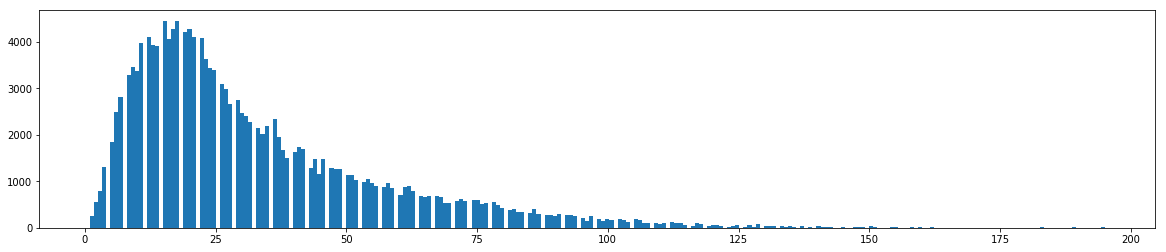

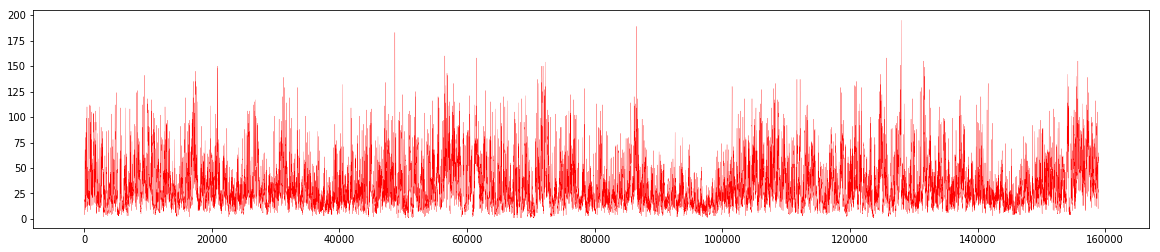

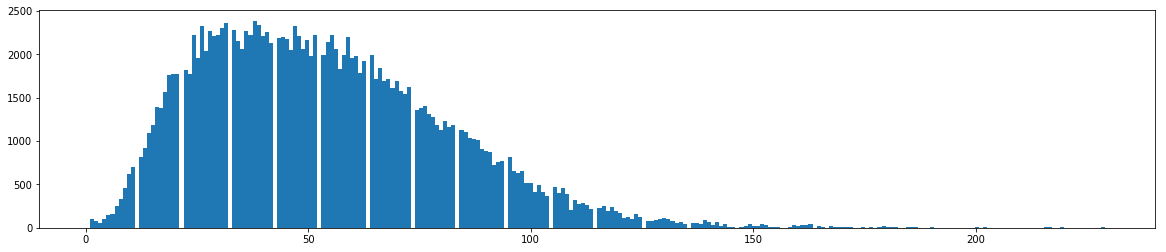

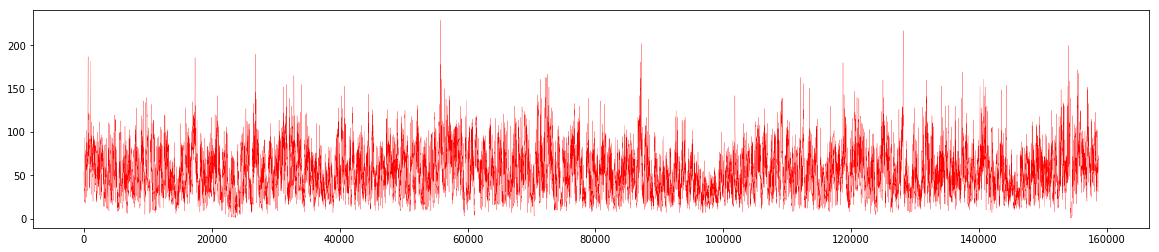

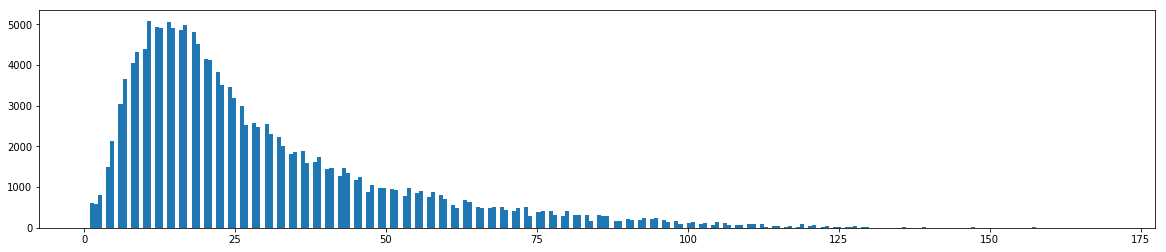

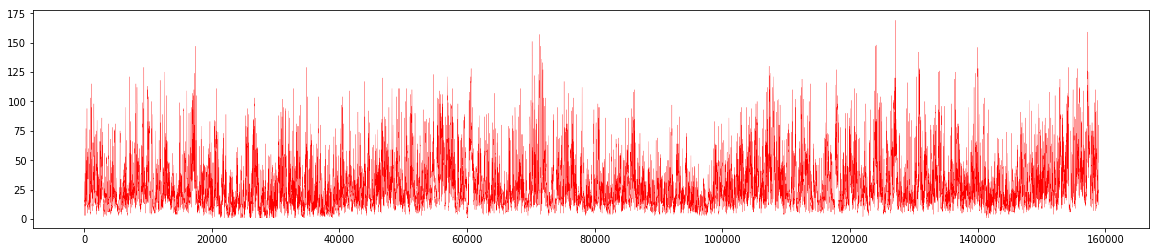

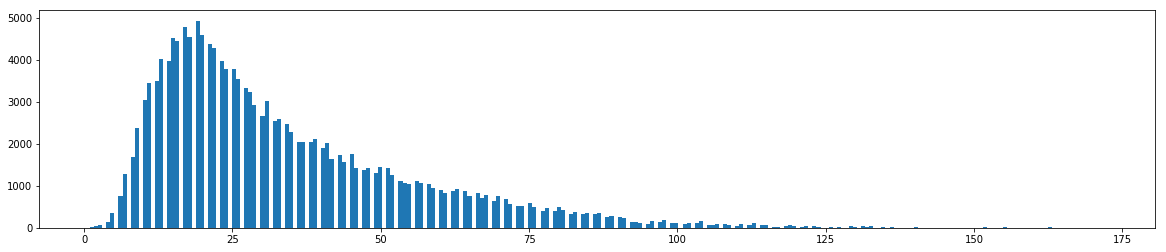

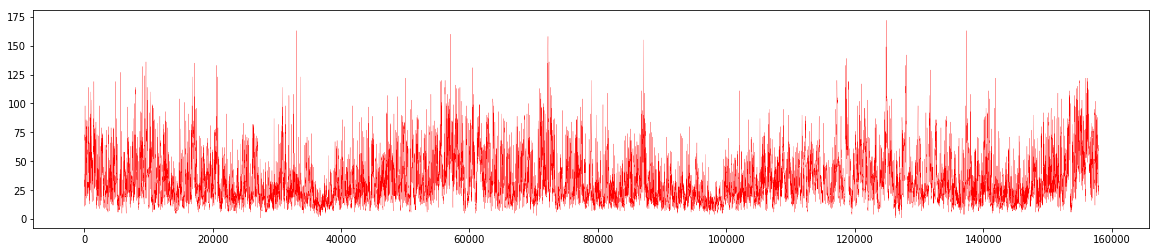

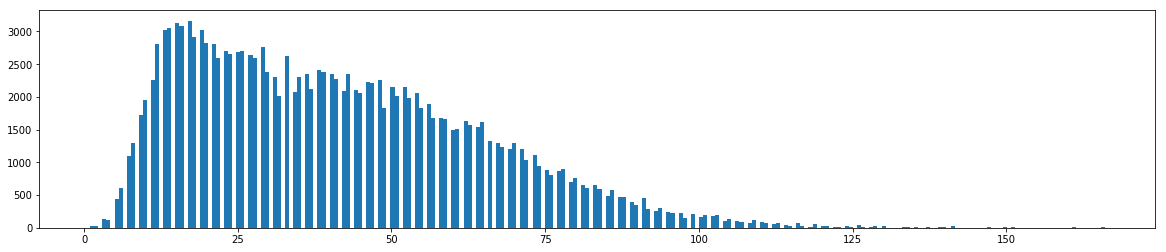

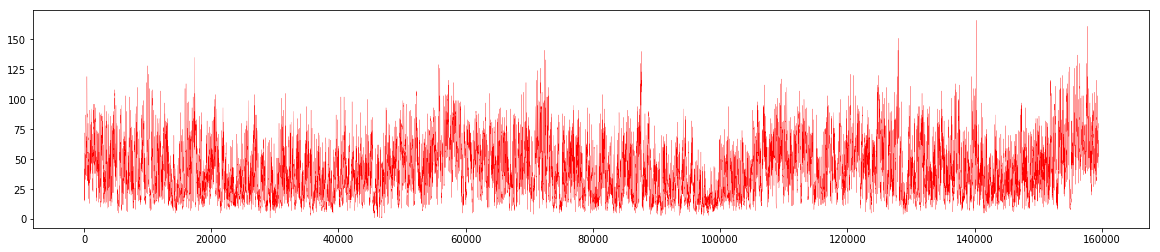

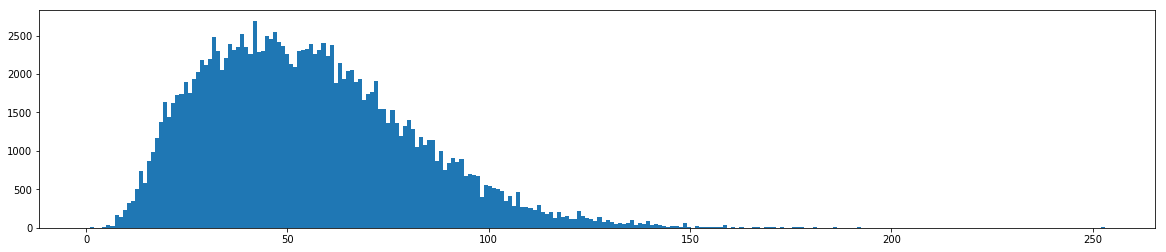

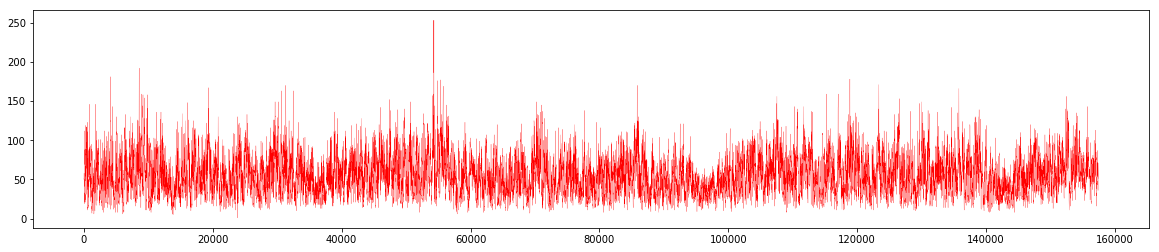

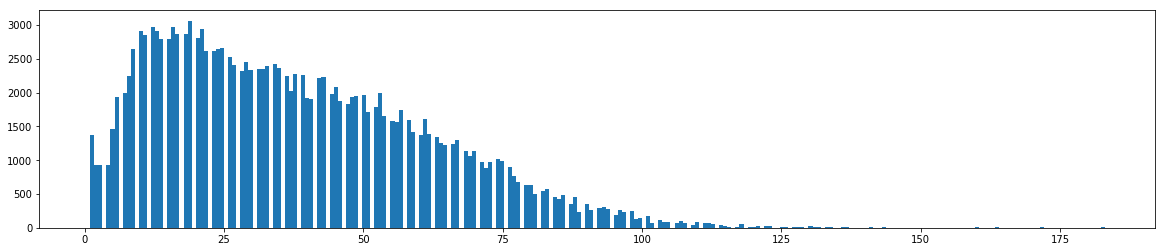

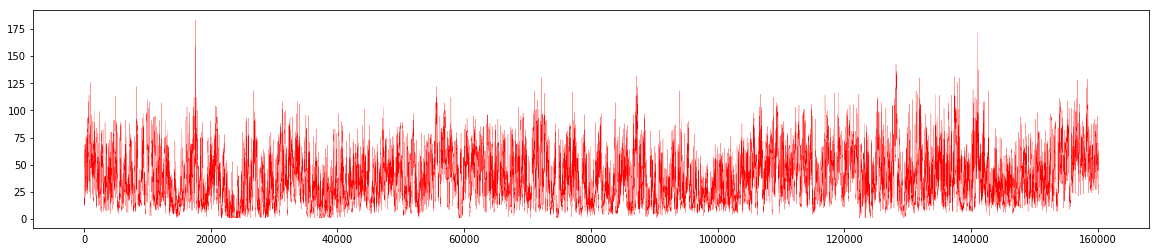

In [233]:
for s in observations['station'].unique():
    plt.figure(figsize=(20, 4))
    plt.hist(observations[observations['station'] == s]['Concentration'], bins=250)
    plt.figure(figsize=(20, 4))
    x_ax = list(range(0, observations[observations['station'] == s].shape[0]))
    plt.plot(x_ax, observations[observations['station'] == s]['Concentration'], 'r-', lw=.2)